# Solution for the Predict Prices task

### Task 1: Load the dataset and calculate the average price and estimated owners, and output to a file named output_1.csv

In [17]:
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.mixture import GaussianMixture
import pandas as pd
from typing import Any, Tuple
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import csv 
import joblib
import torch
import torch.nn as nn
import torch
from dateutil import parser
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

#  Try to use a method for normalizing the data reusable across training and prediction
# In this example, we do standardization on a single column.
# Global scaler for standardization
scaler = StandardScaler()
def normalize_data(df: pd.DataFrame, columns: list, fit: bool = True) -> pd.DataFrame:
    if fit:
        # fits a scaler and transforms the data (used when training)
        df[columns] = scaler.fit_transform(df[columns])
    else:
        # only transforms the data (during inference), reuse the learned scaler above
        df["Estimated owners"] = scaler.transform(df[["Estimated owners"]])
    return df
    

# This function loads the dataset from the given path and returns the features and target variables, as well as the average price, estimated owners, and unique genres
# During evaluation set, the is_eval_dataset flag should be set to True, and the known_genres should be passed as a parameter to ensure the same one-hot encoding is used
# Load dataset and preprocess features using pandas
def load_data(dataset_path: str, is_eval_dataset=False, known_genres=None) -> Tuple[Any, int, int, set]:
    columns_to_drop = ["AppID", "Name", "Recommendations", "Publishers"]
    
    # Load dataset into a pandas DataFrame
    df = pd.read_csv(dataset_path, encoding="utf-8").drop(columns=columns_to_drop, errors='ignore')
    
    # Extract release year
    df["Release date"] = pd.to_datetime(df["Release date"], errors='coerce').dt.year

    # Convert estimated owners to numeric (taking the average for ranges)
    df["Estimated owners"] = df["Estimated owners"].str.split("-").apply(lambda x: (int(x[0]) + int(x[-1])) / 2 if isinstance(x, list) else float(x))
        
    # Convert numerical fields, better be same since the original ones are str type
    df["Positive"] = df["Positive"].astype(float)
    df["Negative"] = df["Negative"].astype(float)
    df["Price"] = df["Price"].astype(float) if not is_eval_dataset else 0.0
    df["Metacritic score"] = df["Metacritic score"].astype(float)
    
    # Compute averages
    avg_price = int(df["Price"].mean())
    avg_owners = int(df["Estimated owners"].mean())
    
    # One-hot encode genres
    df["Genres"] = df["Genres"].fillna("").str.split(",")
    unique_genres = set(df["Genres"].explode().dropna().unique()) if known_genres is None else known_genres
    genre_dummies = df["Genres"].apply(lambda x: pd.Series({genre: int(genre in x) for genre in unique_genres}))
    df = pd.concat([df.drop(columns=["Genres"]), genre_dummies], axis=1)

    # Prepare data for training 
    # Separate features (X) and target (y)
    X = df.drop(columns=["Price"], errors='ignore')
    y = df["Price"].values if not is_eval_dataset else [0] * len(df)

    return df, X, y, avg_price, avg_owners, unique_genres

# Load the full dataset
dataset_loaded, X, y, avg_price, avg_owners, unique_genres = load_data("dataset_train.csv")

# Output to a file named output_1.csv the number of samples, the average price and the average owners
df = pd.DataFrame({
        "Samples": [len(dataset_loaded)],
        "Average Price": [avg_price],
        "Average Owners": [avg_owners],
        "Unique Genres": [len(unique_genres)]
    })
df.to_csv("output_1.csv", index=False)


## Do some data analysis, try to use statistics and plots

### Num rows with missing data: 0


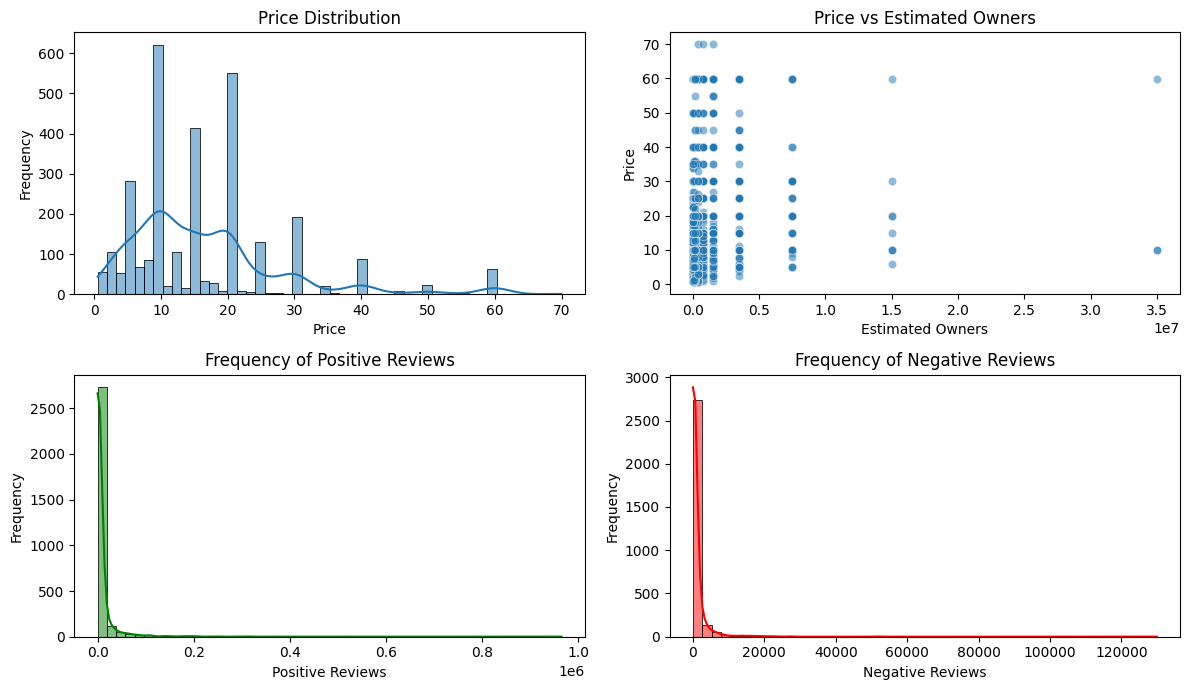

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking for na rows, just to be sure
missing_rows = dataset_loaded[dataset_loaded.isna().any(axis=1)]
print(f"### Num rows with missing data: {len(missing_rows.head())}")

# Function to plot data for multiple columns
def plot_data(df: pd.DataFrame):
    plt.figure(figsize=(12, 7))
    
    plots = [
        ("Price", "Price Distribution", "Price", "Frequency"),
        ("Estimated owners", "Price vs Estimated Owners", "Estimated Owners", "Price"),
        ("Positive", "Frequency of Positive Reviews", "Positive Reviews", "Frequency"),
        ("Negative", "Frequency of Negative Reviews", "Negative Reviews", "Frequency")
    ]
    
    for i, (column, title, xlabel, ylabel) in enumerate(plots, 1):
        plt.subplot(2, 2, i)
        if column == "Estimated owners":
            sns.scatterplot(x=df[column], y=df["Price"], alpha=0.5)
        else:
            sns.histplot(df[column], bins=50, kde=True, color='green' if column == "Positive" else 'red' if column == "Negative" else None)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

plot_data(dataset_loaded)

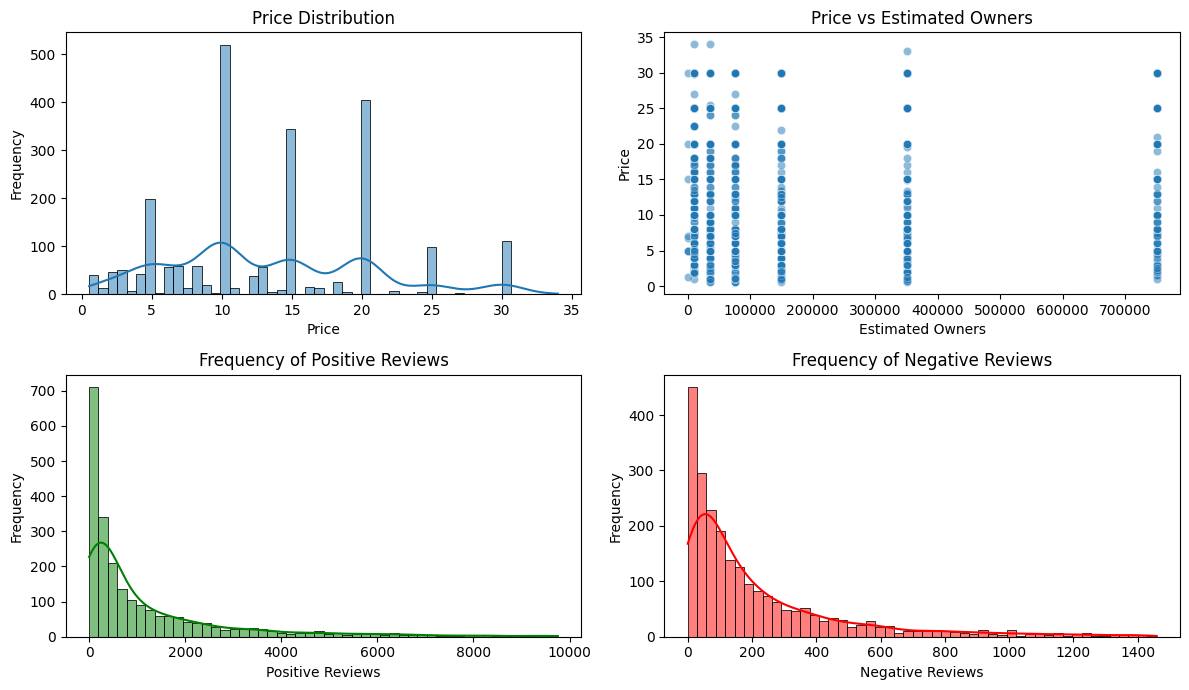

In [19]:
## We see some outliers in both prices and estimated owners
# Step 1: remove outliers using IQR (Interquartile) Method

# Function to remove outliers based on IQR
def remove_outliers(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    df_filtered = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return df_filtered

dataset_loaded_filtered = remove_outliers(dataset_loaded, ["Price", "Estimated owners", "Positive", "Negative"])


# TODO: try to plot and eliminate the outliers from the game genre and price correlation
plot_data(dataset_loaded_filtered)

### Train your model - Play as you like from here to get the best AI model ####

In [20]:
import ipdb 
import numpy as np
from collections import defaultdict

# Convert the dataset to a pandas DataFrame for easier manipulation in other libraries
# y is transformed to an array
X = pd.DataFrame(X)
y = pd.Series(y).ravel()

# Define a simple NN for prediction
class SimplePredictionNetwork(nn.Module):
    def __init__(self, input_size):
        super(SimplePredictionNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# The advanced solution train different models and compares them
def train_model(X: pd.DataFrame, y: pd.Series, model_type: str) -> Any:

    # More pre-processing first
    X["Estimated owners"] = (X["Estimated owners"] - X["Estimated owners"].mean()) / X["Estimated owners"].std()
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Select model based on input type
    if model_type == "linear_regression":
        model = LinearRegression()
    elif model_type == "decision_tree":
        model = DecisionTreeRegressor(random_state=42)
    elif model_type == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == "gaussian_mixture":
        #ipdb.set_trace()
        model = GaussianMixture(n_components=100, random_state=42)  # Assuming 2 clusters
    elif model_type == "deep_learning":
        model = SimplePredictionNetwork(X_train.shape[1])
    else:
        raise ValueError("Unsupported model type")
    
    # Train the model. scikit APIs are light
    if model_type not in ["deep_learning"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_type == "deep_learning":
        # Define the loss and optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.L1Loss()
        
        # Convert input values to tensors
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

        # Training for 10000 epochs
        for epoch in range(10000):  
            optimizer.zero_grad()
            y_trainpred_tensor = model(X_train_tensor)                
            loss = criterion(y_trainpred_tensor, y_train_tensor)
            loss.backward()
            optimizer.step()
        
        # Get the prediction values on the test set
        y_pred = model(X_test_tensor).detach().numpy()
    else: 
        assert False, "Model not recognized"
    
    # Calculate the mean absolute error for regression models
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error ({model_type}):", mae)
    
    return model

# Train and save different models
trained_model = defaultdict(None)
for model_name in ["linear_regression", "decision_tree", "random_forest", "deep_learning"]:
    trained_model[model_name] = train_model(X, y, model_name)
    joblib.dump(trained_model, f"trained_model_{model_name}.pkl")


/tmp/ipykernel_137247/3412726809.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y).ravel()


Mean Absolute Error (linear_regression): 6.893121619888334
Mean Absolute Error (decision_tree): 8.553116666666666
Mean Absolute Error (random_forest): 6.568795833333333
Mean Absolute Error (deep_learning): 7.624184833908081


### Task 2: Load our best model and the evaluation dataset, and make predictions, and output to a file named output_1.csv

In [24]:
def predict_prices(model: Any, dataset_path: str) -> pd.DataFrame:
    
    # Load the evaluation dataset
    loaded_dataset, X_eval, _, _, _, _ = load_data(dataset_path, is_eval_dataset=True, known_genres=unique_genres)
    
    X_eval = pd.DataFrame(X_eval)
    
    # Make predictions
    y_pred = model.predict(X_eval)
    
    # Save the predictions to a file named output_2.csv with a single column of predictions
    # no pandas 
    with open("output_2.csv", "w") as file:
        # Write the header
        file.write("Price\n")
        # Write the predictions
        for pred in y_pred:
            file.write(str(pred) + "\n")

# After studying performance of multiple models, we discovered that on the setup we made so far, the random_forest is the best so use it as predictor
#my_saved_model = joblib.load("trained_model.pkl") # How to load it
predict_prices(trained_model["random_forest"], "dataset_eval.csv")
